Validation MSE: 0.02501809468989109
Validation R²: 0.02694438516224007
Test MSE: 0.004938769281718014
Test R²: 0.6130835640597334


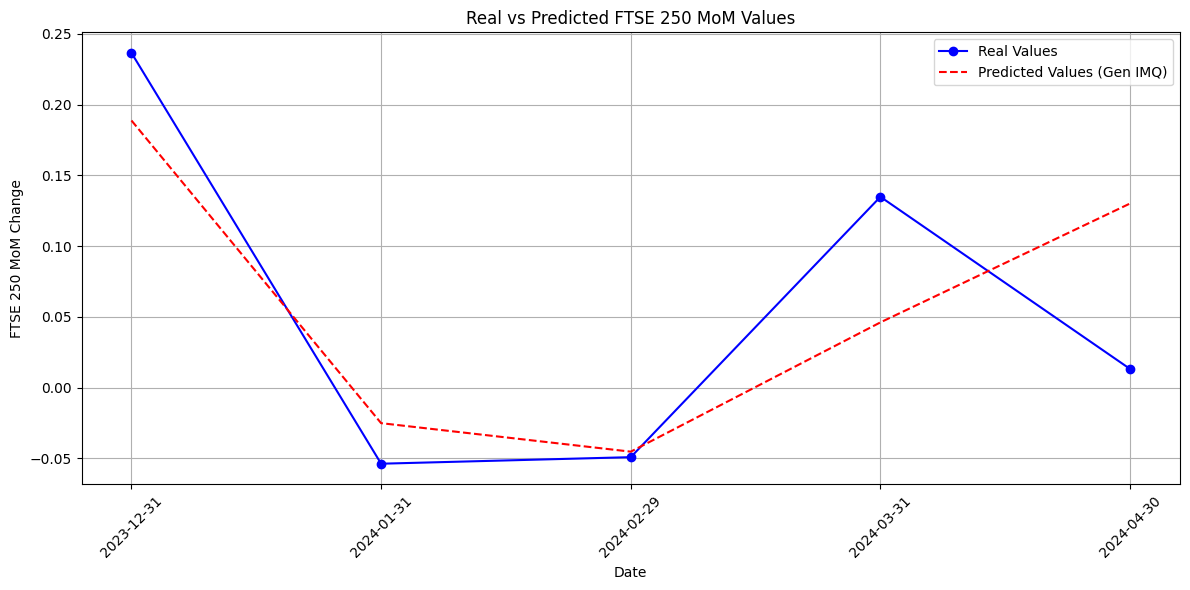

In [1]:
#Inverse Multi-Quadric RBF for short-term prediction - R-squared of 61.3%

import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel, NormalizedKernelMixin
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt

# Custom Generalized Inverse Multiquadric Kernel
class GeneralizedInverseMultiquadricKernel(Kernel, NormalizedKernelMixin):
    def __init__(self, length_scale=0, sigma=1.0, power=1.0):
        self.length_scale = length_scale
        self.sigma = sigma
        self.power = power

    def __call__(self, X, Y=None):
        X = np.atleast_2d(X) / self.length_scale
        if Y is None:
            Y = X
        else:
            Y = np.atleast_2d(Y) / self.length_scale
        dists = np.sum((X[:, np.newaxis, :] - Y[np.newaxis, :, :]) ** 2, axis=2)
        return (dists + self.sigma ** 2) ** (-self.power)

    def diag(self, X):
        return np.ones(X.shape[0])

    def is_stationary(self):
        return True

# Load and preprocess the data
data = pd.read_csv('monthly-data-m3.csv')
data.set_index('month', inplace=True)
data_normalized = data.apply(zscore)
data_normalized = data_normalized.drop(columns=['M2'])
data_normalized['FTSE-250'] = data_normalized['FTSE-250'].diff()
data_normalized['CPI'] = data_normalized['CPI'].diff()
data_normalized['INT'] = data_normalized['INT'].diff()
data_normalized['EXCHG'] = data_normalized['EXCHG'].diff()
data_normalized['M3'] = data_normalized['M3'].diff()
data_normalized = data_normalized.iloc[1:]

# Define features and target variable
X = data_normalized[['CPI', 'INT', 'EXCHG', 'M3']]
Y = data_normalized['FTSE-250']

# Define the training and testing period
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.19)
test_size = len(X) - train_size - val_size

# Sequential split
X_train, X_temp = X[:train_size], X[train_size:]
Y_train, Y_temp = Y[:train_size], Y[train_size:]

X_val, X_test = X_temp[:val_size], X_temp[val_size:]
Y_val, Y_test = Y_temp[:val_size], Y_temp[val_size:]

# Define the custom Generalized IMQ kernel and Gaussian Process Regressor 0.1,0.1,0.1,0.1,1e-5 - loocv
gen_imq_kernel = GeneralizedInverseMultiquadricKernel(length_scale=0.2, sigma=0.1, power=0.4)
gpr = GaussianProcessRegressor(kernel=gen_imq_kernel, alpha=1e-03, normalize_y=True)

# Fit the model on the training set
gpr.fit(X_train, Y_train)

# Make predictions on the validation and test sets
Y_val_pred = gpr.predict(X_val)
Y_test_pred = gpr.predict(X_test)

# Evaluate the model on the validation set
mse_val = mean_squared_error(Y_val, Y_val_pred)
r2_val = r2_score(Y_val, Y_val_pred)
print(f'Validation MSE: {mse_val}')
print(f'Validation R²: {r2_val}')

# Evaluate the model on the test set
mse_test = mean_squared_error(Y_test, Y_test_pred)
r2_test = r2_score(Y_test, Y_test_pred)
print(f'Test MSE: {mse_test}')
print(f'Test R²: {r2_test}')

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Date': data_normalized.index[train_size + val_size:],
    'Real': Y_test,
    'Predicted': Y_test_pred
})

# Plot real vs predicted values for the test set
plt.figure(figsize=(12, 6))

# Plot the real values
plt.plot(plot_data['Date'], plot_data['Real'], label='Real Values', color='blue', marker='o')

# Plot the predicted values
plt.plot(plot_data['Date'], plot_data['Predicted'], label='Predicted Values (Gen IMQ)', color='red', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('FTSE 250 MoM Change')
plt.title('Real vs Predicted FTSE 250 MoM Values')
plt.legend()
plt.grid(True)

# Rotate date labels if necessary
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

plot_data.to_csv('plot_data.csv', index=False)

Validation MSE: 0.009861681068219826
Validation R²: -0.24911098404508403
Test MSE: 0.02669280405698589
Test R²: 0.08704163414778787


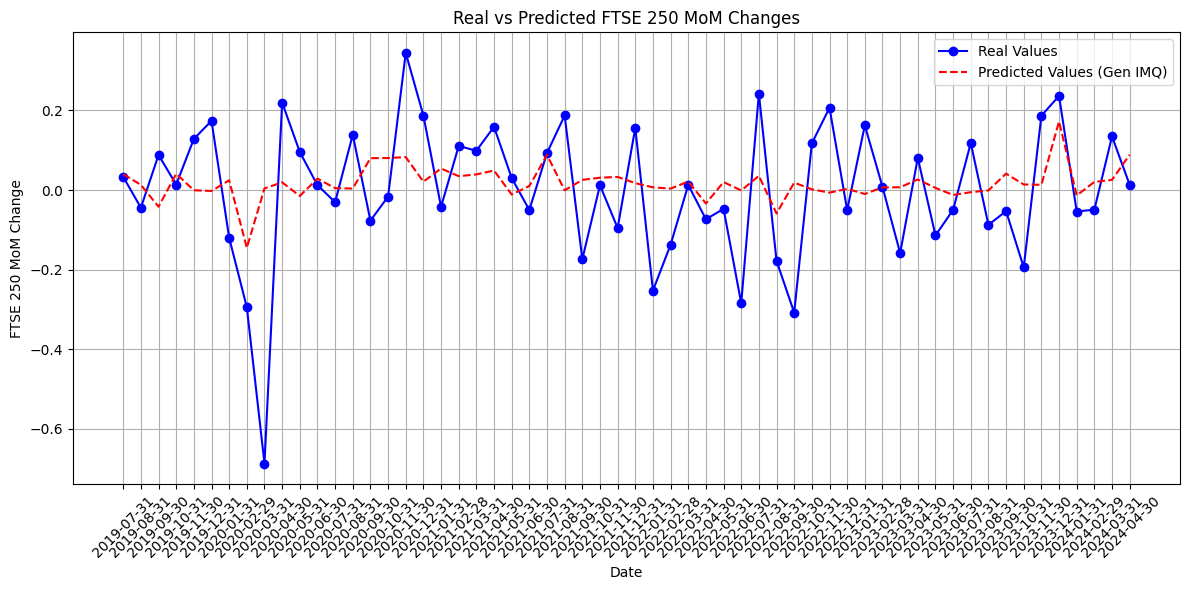

In [3]:
#Inverse Multi-Quadric RBF for long-term trend modelling - R-squared of 8.7%

import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel, NormalizedKernelMixin
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt

# Custom Generalized Inverse Multiquadric Kernel
class GeneralizedInverseMultiquadricKernel(Kernel, NormalizedKernelMixin):
    def __init__(self, length_scale=0, sigma=1.0, power=1.0):
        self.length_scale = length_scale
        self.sigma = sigma
        self.power = power

    def __call__(self, X, Y=None):
        X = np.atleast_2d(X) / self.length_scale
        if Y is None:
            Y = X
        else:
            Y = np.atleast_2d(Y) / self.length_scale
        dists = np.sum((X[:, np.newaxis, :] - Y[np.newaxis, :, :]) ** 2, axis=2)
        return (dists + self.sigma ** 2) ** (-self.power)

    def diag(self, X):
        return np.ones(X.shape[0])

    def is_stationary(self):
        return True

# Load and preprocess the data
data = pd.read_csv('monthly-data-m3.csv')
data.set_index('month', inplace=True)
data_normalized = data.apply(zscore)
data_normalized = data_normalized.drop(columns=['M2'])
data_normalized['FTSE-250'] = data_normalized['FTSE-250'].diff()
data_normalized['CPI'] = data_normalized['CPI'].diff()
data_normalized['INT'] = data_normalized['INT'].diff()
data_normalized['EXCHG'] = data_normalized['EXCHG'].diff()
data_normalized['M3'] = data_normalized['M3'].diff()
data_normalized = data_normalized.iloc[1:]

# Define features and target variable
X = data_normalized[['CPI', 'INT', 'EXCHG', 'M3']]
Y = data_normalized['FTSE-250']

# Define the training and testing period
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

# Sequential split
X_train, X_temp = X[:train_size], X[train_size:]
Y_train, Y_temp = Y[:train_size], Y[train_size:]

X_val, X_test = X_temp[:val_size], X_temp[val_size:]
Y_val, Y_test = Y_temp[:val_size], Y_temp[val_size:]

# Define the custom Generalized IMQ kernel and Gaussian Process Regressor
gen_imq_kernel = GeneralizedInverseMultiquadricKernel(length_scale=0.1, sigma=0.1, power=0.1)
gpr = GaussianProcessRegressor(kernel=gen_imq_kernel, alpha=1e-05, normalize_y=True)

# Fit the model on the training set
gpr.fit(X_train, Y_train)

# Make predictions on the validation and test sets
Y_val_pred = gpr.predict(X_val)
Y_test_pred = gpr.predict(X_test)

# Evaluate the model on the validation set
mse_val = mean_squared_error(Y_val, Y_val_pred)
r2_val = r2_score(Y_val, Y_val_pred)
print(f'Validation MSE: {mse_val}')
print(f'Validation R²: {r2_val}')

# Evaluate the model on the test set
mse_test = mean_squared_error(Y_test, Y_test_pred)
r2_test = r2_score(Y_test, Y_test_pred)
print(f'Test MSE: {mse_test}')
print(f'Test R²: {r2_test}')

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Date': data_normalized.index[train_size + val_size:],
    'Real': Y_test,
    'Predicted': Y_test_pred
})

# Plot real vs predicted values for the test set
plt.figure(figsize=(12, 6))

# Plot the real values
plt.plot(plot_data['Date'], plot_data['Real'], label='Real Values', color='blue', marker='o')

# Plot the predicted values
plt.plot(plot_data['Date'], plot_data['Predicted'], label='Predicted Values (Gen IMQ)', color='red', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('FTSE 250 MoM Change')
plt.title('Real vs Predicted FTSE 250 MoM Changes')
plt.legend()
plt.grid(True)

# Rotate date labels if necessary
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()